# Computing regression slopes, variances and Kalman gains for iso2k records

End product: a triptychon: regression slope, error, kalman gain 


In [2]:
import numpy as np
import xarray as xr
import cftime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import linregress
from matplotlib import ticker

import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.append('/home/mchoblet/paleoda')

import psm_pseudoproxy
import dataloader
import utils

import proxy_loader
import cartopy.crs as ccrs
import cartopy.feature as cfeature  

import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
###WRAPPER FOR MAKING THE PROXY TABLE
def iso2k_table(path='/home/mchoblet/raw_data/proxies/iso2k/iso2k1_0_0.pkl',start=0,end=2013,minrecords=20,min_start=1951,min_end=1980):
    #read in file, select permil, glacier ice, d18O, primary time series=True or missing
    TS=proxy_loader.read_iso_pkl(path)
    #change TS to a table with nans where no time available
    #time is rounded to the nearest integer, multiple values per year are rounded
    table=proxy_loader.make_table(TS,start=start,end=end)
    #only select records which have at least 30 values between 850 and 1850 (39 or 30 doesn't change anything actually)
    #doesn't throw out the rest of the time
    table_minimum=proxy_loader.minimum_of_records(table,minrecords,(min_start,min_end))
    #table_minimum=minimum_of_records(table,20,(0,2013))
    #slice down table 
    table_cut=proxy_loader.cut_time(table_minimum,start,end)
    #eject crap value sites (theres one down to -150)
    for s in table_cut.site:
        mini= np.nanmin(table_cut.sel(site=s).values) 
        if mini<-60:
            table_cut=table_cut.where(table_cut.site!=s,drop=True)
    table_cut=proxy_loader.drop_empty(table_cut)
    print('Final number of records',len(table_cut.site))
    ##fix longitudes: https://stackoverflow.com/questions/46962288/change-longitude-from-180-to-180-to-0-to-360
    table_cut.coords['lon'] = table_cut.coords['lon'] % 360
    table_cut= table_cut.sortby(table_cut.lon)
    return table_cut

In [5]:
#for fitting to berkeley earth
iso2k_1956=iso2k_table(path='/home/mchoblet/raw_data/proxies/iso2k/iso2k1_0_0.pkl',start=0,end=2013,minrecords=20,min_start=1956,min_end=2013)

Dataset reduced from  198  glacier ice records to  165 records
Final number of records 106


In [6]:
#for fitting to 20CR
iso2k_1900=iso2k_table(path='/home/mchoblet/raw_data/proxies/iso2k/iso2k1_0_0.pkl',start=0,end=2013,minrecords=10,min_start=1900,min_end=2000)

Dataset reduced from  198  glacier ice records to  165 records
Final number of records 144


In [7]:
def regress(proxy_data,instrumental_data,regress_start=1900,anom=True,anom_time=[1951,1990],norm=False):
    #exchange instrumental_data time (annoying slicing calendar thing)
    instrumental_data['time']=xr.cftime_range(start=str(instrumental_data.time.dt.year[0].values.tolist()),end=str(instrumental_data.time.dt.year[-1].values.tolist()),freq='YS',calendar='noleap')
    if anom:
        #create separate time objects for slicing (.sel(time=slice) has a calendar bug)
        start=cftime.datetime(anom_time[0], 1, 1, 0, 0, 0, 0, calendar='365_day')
        end=cftime.datetime(anom_time[1], 1, 1, 0, 0, 0, 0, calendar='365_day')
        try:
            proxy_data=proxy_data-proxy_data.sel(time=slice(start,end)).mean('time')
        except:
            proxy_data=proxy_data-proxy_data.sel(time=slice(str(anom_time[0]),str(anom_time[1]))).mean('time')

    if norm:
        proxy_data=proxy_data/proxy_data.std('time',skipna=True)
        instrumental_data=instrumental_data/instrumental_data.std('time',skipna=True)

    regress_start=cftime.datetime(regress_start, 1, 1, 0, 0, 0, 0, calendar='365_day')  
    #slice proxy_data
    proxy_data=proxy_data.sel(time=slice(regress_start,None))
    
    #saving values for afterwards
    slopes=[]
    intercepts=[]
    errors=[]
    sites=[]
    lats=[]
    lons=[]

    proxies=[]
    instrumental=[]
    times=[]

    for site in proxy_data.site:
        record=proxy_data.sel(site=site).dropna('time')
        #print(len(record.time))
        record_times=record.time.values
        
        lat=record['lat']
        lon=record['lon']
        #get temperature from instrumental data
        instru_loc=instrumental_data.sel(lat=lat,lon=lon,method='nearest')
        instru_time=instru_loc.time
        
        instru_time2=instru_time.where(instru_loc!=0,drop=True).values
        
        if anom:
            try:    
                instru_loc=instru_loc-instru_loc.sel(time=slice(start,end)).mean('time')
            except:
                instru_loc=instru_loc-instru_loc.sel(time=slice(str(anom_time[0]),str(anom_time[1]))).mean('time')
        
        common_time=np.sort(list(set(record_times).intersection(set(instru_time2))))
    
    #only do linear regression for more than 10 data points:
        if len(common_time) > 20:
            #print(len(common_time))
            record_vals=record.sel(time=common_time).values
            instru_vals=instru_loc.sel(time=common_time).values
            
            slope, intercept, r, p, se =linregress(record_vals,instru_vals)
            
            #print('site ',site.values.tolist(), ' slope ', slope)
            sites.append(site)
            lats.append(lat)
            lons.append(lon)
            
            slopes.append(slope)
            intercepts.append(intercept)
            errors.append(se)
            
            proxies.append(record_vals)
            instrumental.append(instru_vals)
            times.append(common_time)
        else:
            pass
            #print('record ',site.values.tolist(),' too short')
            
        final=xr.DataArray(slopes,dims=('site'))
        final['site']=sites
        final['slope']=('site',slopes)
        final['intercept']=('site',intercepts)
        
        #USING THE SQUARED RESIDUALS BECAUSE THATS THE VARIABLE TO COMPARE TO IN THE KALMAN GAIN   
        final['error']=('site',errors)
        final['lat']=('site',lats)
        final['lon']=('site',lons)
        
    return final,proxies,instrumental,times

In [8]:
def aufteilung(data,df=True):
    #greenland 
    data_green=data.where(data.lat > 60, drop=True).where(data.lon > 300,drop=True)
    #antarctica
    data_ant=data.where(data.lat < -60, drop=True)
    #non-polar
    data_nonp=data.where(data.lat > -60, drop=True).where(data.lat < 60, drop=True)

    #rest
    sites=set(np.concatenate([data_green.site.values,data_ant.site.values,data_nonp.site.values]))
    all_sites=set(data.site.values)
    rest_site=list(all_sites-sites)
    rest=data.sel(site=rest_site)

    #make dataframe
    if df:
        names=np.concatenate([np.repeat('Greenland',len(data_green)),np.repeat('Antarctica',len(data_ant)),np.repeat('Nonpolar',len(data_nonp)),np.repeat('Arctic',len(rest))])
        slopes=np.concatenate([data_green.values,data_ant.values,data_nonp.values,rest.values])
        dataframe = pd.DataFrame(data=[slopes,names]).T
        dataframe.columns=['slope','region']   
        
    return data_green, data_ant, data_nonp, rest,dataframe


In [9]:
#BE_path='/home/mchoblet/raw_data/calibration/Land_and_Ocean_LatLong1.nc'
#land only
BE_path='/home/mchoblet/raw_data/calibration/Complete_TAVG_LatLong1.nc'
BE=xr.open_dataset(BE_path)['temperature']
#CONVERT BE LONGITUDES TO 0-360
BE['longitude']=BE['longitude'] % 360
BE= BE.sortby(BE.longitude)
BE=BE.rename({'latitude':'lat'})
BE=BE.rename({'longitude':'lon'})

#echange time of dataset (else calendar-problem when slicing)
new_time=xr.cftime_range(start='1750',periods=3272,freq='MS',calendar='365_day')
BE['time']=new_time

In [10]:
BE_mean=dataloader.annual_mean(BE,avg=None,check_nan=False)
zeros=np.count_nonzero(BE_mean==0)
total=len(BE_mean.values.reshape(-1))

In [11]:
BE_regress,prox_BE,instr_BE,time_BE=regress(iso2k_1900,BE_mean,regress_start=1956,anom=True,norm=False)
#green,ant,nonp,rest=aufteilung(BE_regress,df=True)
_,_,_,_,df_BE=aufteilung(BE_regress,df=True)

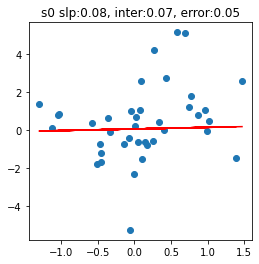

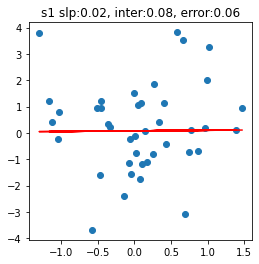

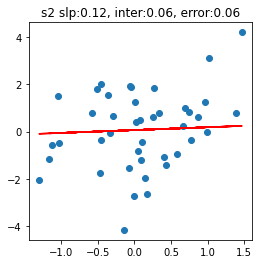

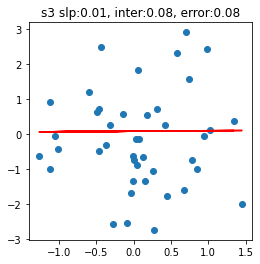

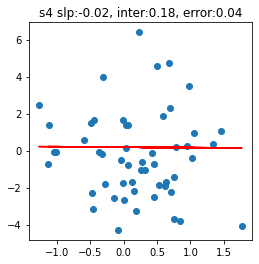

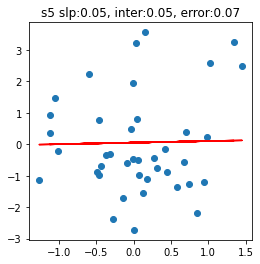

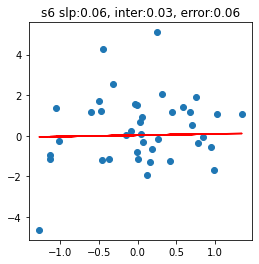

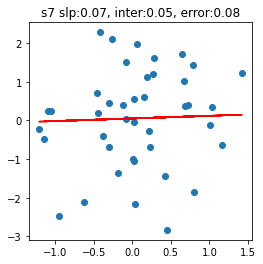

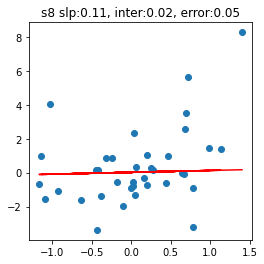

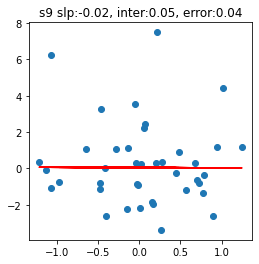

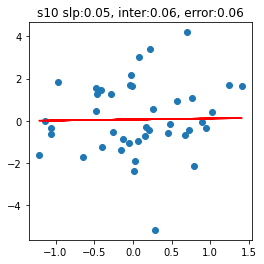

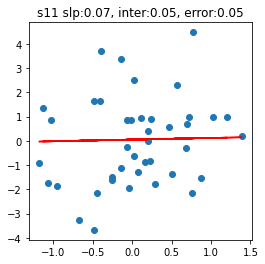

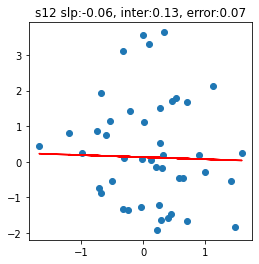

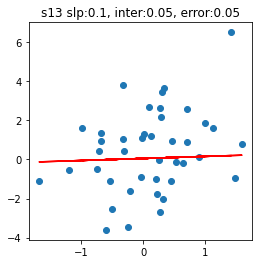

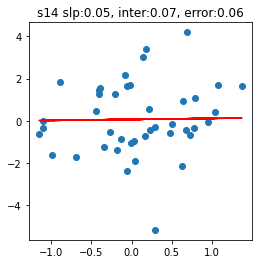

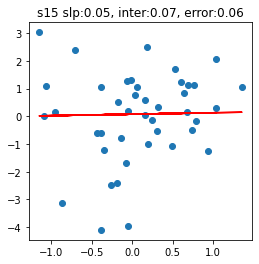

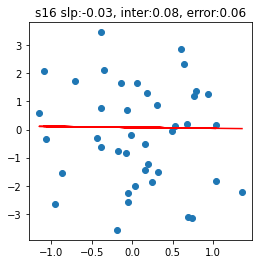

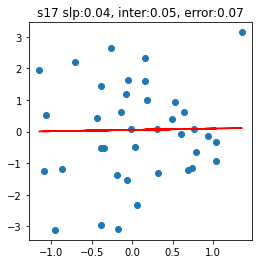

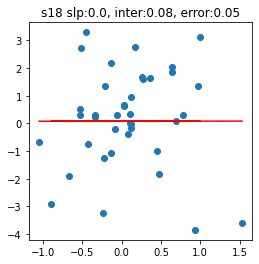

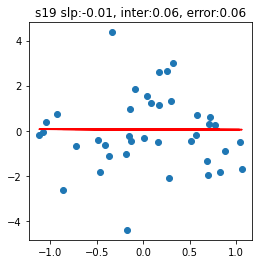

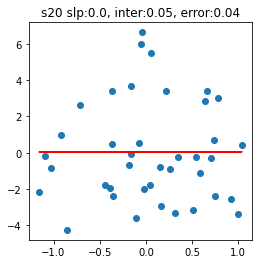

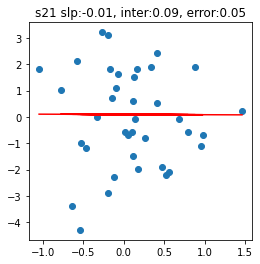

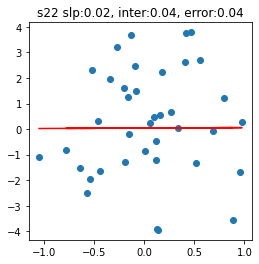

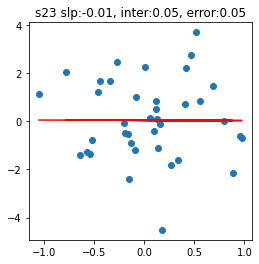

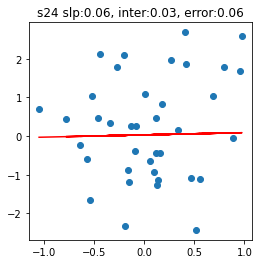

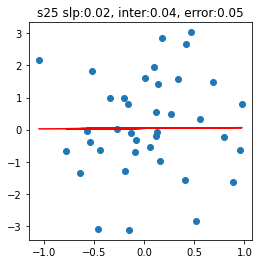

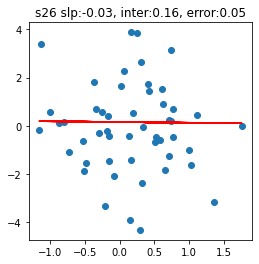

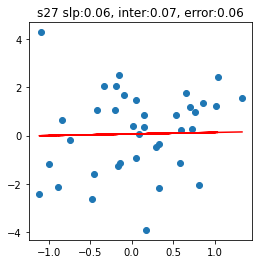

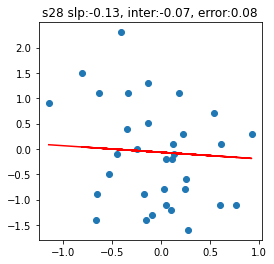

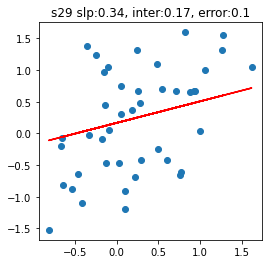

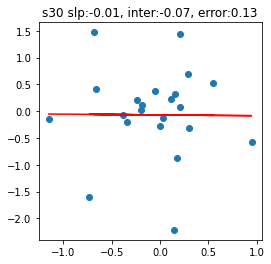

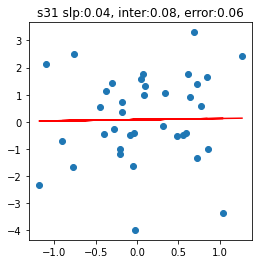

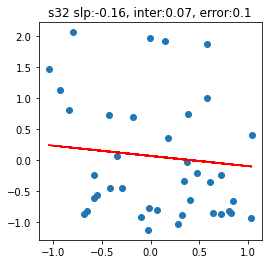

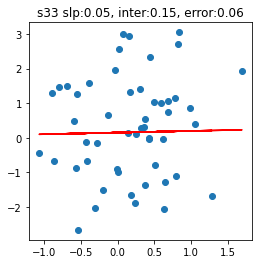

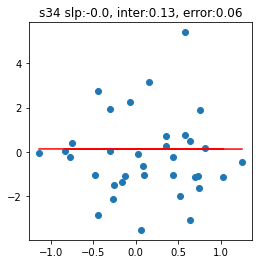

KeyboardInterrupt: 

In [12]:
new_table=BE_regress
records=prox_BE
instru=instr_BE

for i in range(len(new_table.site)):
    plt.figure(figsize=(4,4))
    x=np.array(instru[i])
    slpe=new_table['slope'][i].values.tolist()
    intrcpt=new_table['intercept'][i].values.tolist()
    plt.scatter(x,records[i])
    plt.plot(x, intrcpt + slpe*x, 'r', label='fitted line')
    title_string='s'+str(i)+' slp:'+str(np.round(slpe,2))+', inter:'+str(np.round(intrcpt,2))+', error:'+ str(np.round(new_table['error'][i].values.tolist(),2))
    plt.title(title_string)
    plt.show()

In [14]:
BE_regress,prox_BE,instr_BE,time_BE=regress(iso2k_1900,BE_mean,regress_start=1900,anom=True,norm=False)
#green,ant,nonp,rest=aufteilung(BE_regress,df=True)
_,_,_,_,df_BE=aufteilung(BE_regress,df=True)

In [15]:
_,_,_,_,df_BE_err=aufteilung(BE_regress['error'],df=True)
#convert the slope to the square root!
df_BE_err['slope']=np.sqrt(df_BE_err['slope'].astype(float))

Text(45.0, 0.5, 'Slope')

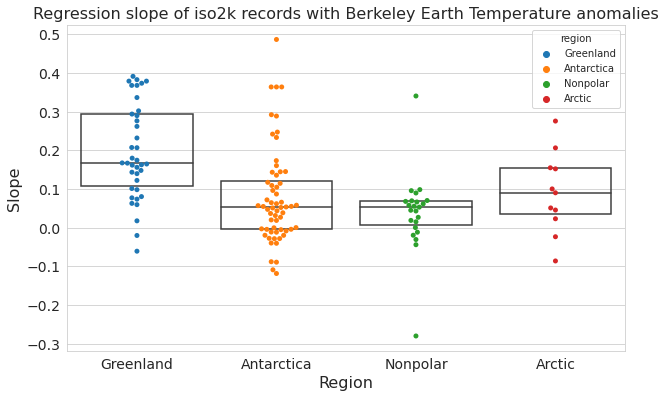

In [16]:
BE_regress,prox_BE,instr_BE,time_BE=regress(iso2k_1900,BE_mean,regress_start=1900,anom=True,norm=False)
#green,ant,nonp,rest=aufteilung(BE_regress,df=True)
_,_,_,_,df_BE=aufteilung(BE_regress,df=True)

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.swarmplot(x="region", y='slope',data=df_BE,hue='region')
ax = sns.boxplot(x="region", y='slope',data=df_BE, showcaps=False,boxprops={'facecolor':'None'},showfliers=False,whiskerprops={'linewidth':0})
plt.title('Regression slope of iso2k records with Berkeley Earth Temperature anomalies',fontsize=16)
plt.xlabel('Region',fontsize=16)
plt.ylabel('Slope',fontsize=16)

Text(56.625, 0.5, '$\\epsilon$')

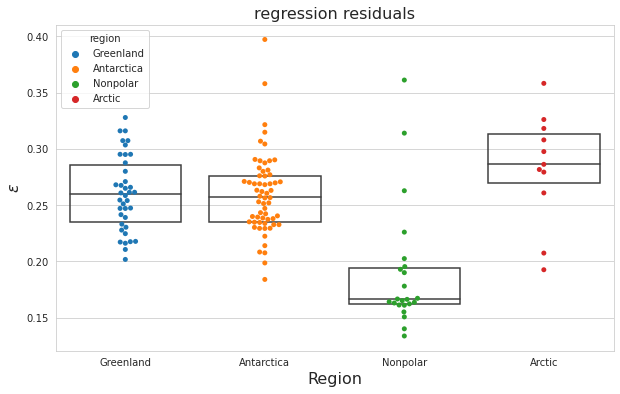

In [32]:
#regression residuals

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.swarmplot(x="region", y='slope',data=df_BE_err,hue='region')
ax = sns.boxplot(x="region", y='slope',data=df_BE_err,
        showcaps=False,boxprops={'facecolor':'None'},
        showfliers=False,whiskerprops={'linewidth':0})
plt.title('regression residuals',fontsize=16)
plt.xlabel('Region',fontsize=16)
plt.ylabel('$\epsilon$',fontsize=16)

/tmp/ipykernel_583836/1245701366.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb=plt.colorbar(plot)


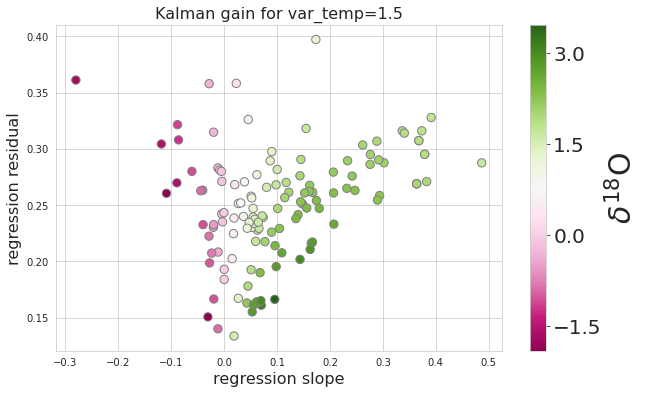

In [66]:
slopes=df_BE['slope'].values.astype('float')
errs=df_BE_err['slope'].values.astype('float')
#color
temp_var=1.5

c=slopes*temp_var/((slopes**2)*temp_var+errs**2)

fig=plt.figure(figsize=(10,6))
plot=plt.scatter(slopes,errs,c=c,s=70,cmap='PiYG',edgecolors='grey')
plt.title('Kalman gain for var_temp=1.5',fontsize=16)
plt.xlabel('regression slope',fontsize=16)
plt.ylabel('regression residual',fontsize=16)

#for i, txt in enumerate(slopes):
#    plt.annotate(np.round(c[i],1), (slopes[i], errs[i]),size=8)

cb=plt.colorbar(plot)

cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label(label=r'$\delta^{18}$O',fontsize=30)

/tmp/ipykernel_819496/3276901383.py:82: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb=fig_trypt.colorbar(p0, cax=ax_cbar1, orientation='vertical')


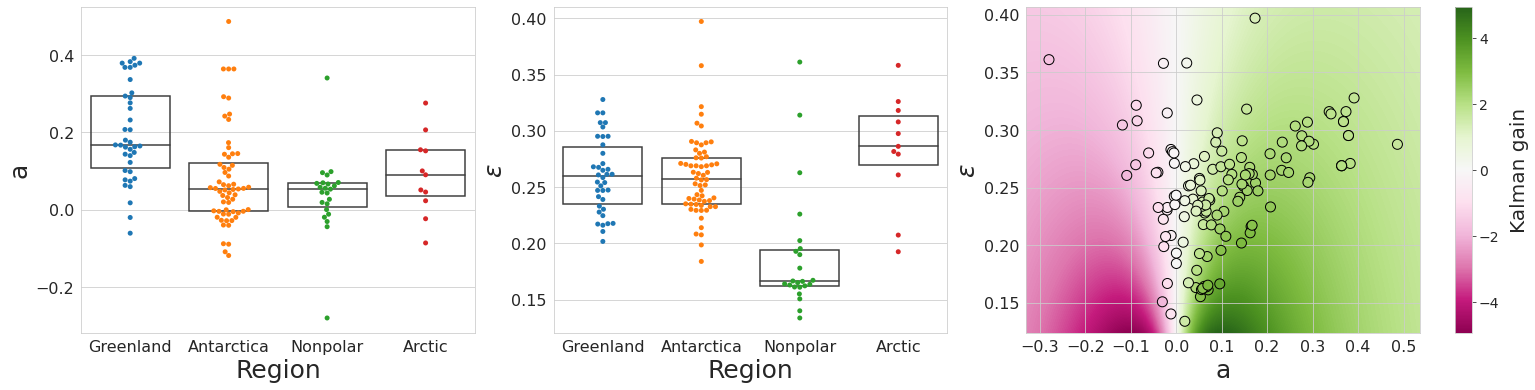

In [42]:
import matplotlib as mpl
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

# TRYPTICHON PLOT 
fig_trypt,axs=plt.subplots(1,3,figsize=(24,6))

import matplotlib as mpl
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

ax=axs[0]
sns.swarmplot(x="region", y='slope',data=df_BE,hue='region',ax=ax,legend=False)
sns.boxplot(x="region", y='slope',data=df_BE, showcaps=False,boxprops={'facecolor':'None'},showfliers=False,whiskerprops={'linewidth':0},ax=ax)
ax.set_xlabel('Region',fontsize=25)
ax.set_ylabel('a',fontsize=25)
ax.locator_params(nbins=6)

ax=axs[1]
sns.swarmplot(x="region", y='slope',data=df_BE_err,hue='region',ax=ax,legend=False)
sns.boxplot(x="region", y='slope',data=df_BE_err,
        showcaps=False,boxprops={'facecolor':'None'},
        showfliers=False,whiskerprops={'linewidth':0},ax=ax)
ax.set_xlabel('Region',fontsize=25)
ax.set_ylabel('$\epsilon$',fontsize=25)

slopes=df_BE['slope'].values.astype('float')
errs=df_BE_err['slope'].values.astype('float')
#color
temp_var=1.5

c=slopes*temp_var/((slopes**2)*temp_var+errs**2)

import copy
df_BE_kalman=copy.deepcopy(df_BE_err)
df_BE_kalman['slope']=c

#third plot -> imshow heat map!
slop_min=np.min(slopes)
slop_max=np.max(slopes)
slope=np.linspace(slop_min-0.05,slop_max+0.05,1000)

err_min=np.min(errs)
err_max=np.max(errs)
errors=np.linspace(err_min-0.01,err_max+0.01,1000)

x,y=np.meshgrid(slope,errors)
def kalman(X,Y,temp_var):
    return X*temp_var/((X**2)*temp_var+Y**2)
k=kalman(x,y,1.5)
c=kalman(slopes,errs,temp_var)
#margin=0.05
#margin2=0.01
#extent = np.min(x)-margin, np.max(x)-margin, np.min(y)-margin2, np.max(y)-margin2
ax=axs[2]

vmax=k.max()
vmin=k.min()

p0=ax.scatter(slopes,errs,c=c,s=100,cmap='PiYG',edgecolors='black',vmax=vmax,vmin=vmin)
#extent = np.min(x)-margin, np.max(x)-margin, np.min(y)-margin2, np.max(y)-margin2
extent = np.min(x), np.max(x), np.min(y), np.max(y)
#extent=[-len(slope)/2., len(slope)/2., -len(errs)/2., -len(errs)/2. ]
p0=ax.imshow(k,extent=extent,cmap='PiYG',aspect='auto',origin='lower',vmax=vmax,vmin=vmin)
#p0=ax.imshow(k,cmap='PiYG',aspect='auto',origin='lower',vmax=vmax,vmin=vmin)

#ax.set_xlim(-0.1,0)
#ax.set_ylim(0.13,0.16)

#plt.title('Kalman gain for var_temp=1.5',fontsize=16)
plt.xlabel('a',fontsize=25)
plt.ylabel('$\epsilon$',fontsize=25)


#for i, txt in enumerate(slopes):
#    plt.annotate(np.round(c[i],1), (slopes[i], errs[i]),size=8)
pos0 = ax.get_position().get_points().flatten()
#p2 = ax0.get_position().get_points().flatten()
    
ax_cbar1 = fig_trypt.add_axes([pos0[2] +0.02, pos0[1], 0.01, pos0[3]-pos0[1]])
cb=fig_trypt.colorbar(p0, cax=ax_cbar1, orientation='vertical')
cb.set_label('Kalman gain',fontsize=20,labelpad=10)
#cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()



In [ ]:
"""
cb=plt.colorbar(plot)
cb.ax.tick_params(labelsize=20)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label(label=r'$\delta^{18}$O',fontsize=30)
"""

In [44]:
fig_trypt.savefig('/home/mchoblet/plots_thesis/4/stat_psm.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

In [123]:
slop_min=np.min(slopes)
slop_max=np.max(slopes)
slope=np.linspace(slop_min,slop_max,1000)

err_min=np.min(errs)
err_max=np.max(errs)
errors=np.linspace(err_min,err_max,1000)


In [147]:
x,y=np.meshgrid(slope,errors)
def kalman(X,Y,temp_var):
    return X*temp_var/((X**2)*temp_var+Y**2)
k=kalman(x,y,1.5)
extent = np.min(x), np.max(x), np.min(y), np.max(y)

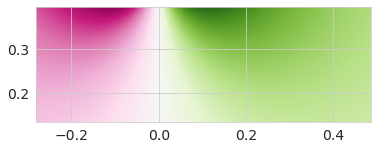

In [149]:
plt.imshow(k,extent=extent,cmap='PiYG')

In [ ]:
#save if result satisfactory
#fig.savefig('/home/mchoblet/plots_thesis/kalman_sisal_nopsm.pdf', format='pdf',bbox_inches='tight')